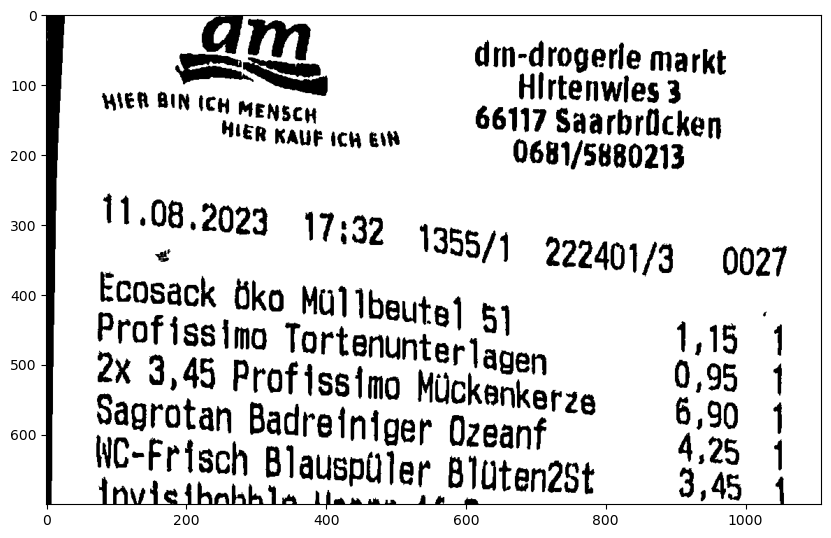

In [1]:
import numpy as np
import argparse
import imutils
import cv2
import os
import matplotlib.pyplot as plt
import doxapy
import sys
import time

inputfile = '/home/elena/Documents/Projects/kassenzettel-django-react/testings/receipe-upload-_oqp9us3.jpg'
#inputfile = '/home/elena/Documents/Projects/kassenzettel-django-react/testings/testbild.png'
img = cv2.imread(inputfile, cv2.IMREAD_GRAYSCALE)
start = 200
stop = start + 700

img_snippet = img[start:stop,:]
img_copy = cv2.cvtColor(img_snippet,cv2.COLOR_GRAY2RGB)

binary_image = np.empty(img_snippet.shape, img_snippet.dtype)
sauvola = doxapy.Binarization(doxapy.Binarization.Algorithms.ISAUVOLA)
sauvola.initialize(img_snippet)
sauvola.to_binary(binary_image, {"window": 45, "k": 0.009})

#Plot the snippet
plt.figure(figsize=(10,10))
plt.imshow(binary_image, cmap='gray')
plt.show()

In [2]:
#Invert the binary image
binary_image = cv2.bitwise_not(binary_image)
# Calc connected components
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)

# Calculate the mean vector and the covariance matrix of the pixels in each connected component
means = np.empty((num_labels,2))
covs = np.empty((num_labels,2,2))
eigenvalues = np.empty((num_labels,2))
eigenvectors = np.empty((num_labels,2,2))

labelsForDelete = []

for i in range(1,num_labels):
    mask = np.zeros(binary_image.shape, np.uint8)
    mask[labels == i] = 255
    
    xy_coords = np.flip(np.column_stack(np.where(mask == 255)), axis=1)
    #means[i] = np.mean(xy_coords, axis=0)  # Is equal to the centroid
    covs[i] = np.cov(xy_coords, rowvar=False)

    # Calculate the eienvalues and eigenvectors of the covariance matrix
    eigenvalues[i], eigenvectors[i] = np.linalg.eig(covs[i])

    #Sort the eigenvalues and eigenvectors
    idx = eigenvalues[i].argsort()[::-1]
    eigenvalues[i] = eigenvalues[i][idx]
    eigenvectors[i] = eigenvectors[i][:,idx]

    #If eigenvalue1 / eigenvalue2 > 15, remove the corresponding connected component
    if eigenvalues[i,0] / eigenvalues[i,1] > 15**2:
        labelsForDelete.append(i)


#Delete the connected components in list
labels = np.delete(labels, labelsForDelete, axis=0)
num_labels = num_labels - len(labelsForDelete)
stats = np.delete(stats, labelsForDelete, axis=0)
centroids = np.delete(centroids, labelsForDelete, axis=0)
eigenvalues = np.delete(eigenvalues, labelsForDelete, axis=0)
eigenvectors = np.delete(eigenvectors, labelsForDelete, axis=0)

# Create a new image with only the ellipses
ellipseMask = np.zeros(binary_image.shape, np.uint8)
for i in range(1,num_labels):
    # Plot eigenvalues as ellipses in black and white image
    cv2.ellipse(ellipseMask,(int(centroids[i,0]),int(centroids[i,1])),(int(np.sqrt(eigenvalues[i,0])),int(np.sqrt(eigenvalues[i,1]))),np.rad2deg(np.arctan2(eigenvectors[i,0,1],eigenvectors[i,0,0])),0,360,(255,255,255),-1)

height, width = ellipseMask.shape[:2] 
# get the center coordinates of the image to create the 2D rotation matrix 
center = (width/2, height/2) 
# Get diagonal of the image
diagonal = np.sqrt(width**2 + height**2)

# Pad the ellipseMask with zeros to around the center to fit the diagonal
ellipseMask = np.pad(ellipseMask, ((int(diagonal/2 - height/2),int(diagonal/2 - height/2)),(int(diagonal/2 - width/2),int(diagonal/2 - width/2))), 'constant', constant_values=(0,0))
heightPadded, widthPadded = ellipseMask.shape[:2] 
centerPadded = (widthPadded/2, heightPadded/2) 

# Shift centroids by padded amount
centroids = centroids + (diagonal/2 - width/2, diagonal/2 - height/2)

print(num_labels)


307


In [3]:
def changes_in_bitoperation(sequence: np.ndarray) -> int:
    '''
    Count the number of bit flips in a binary sequence (2x faster than itertools solution), adopten from: 
    https://stackoverflow.com/questions/70300297/is-there-a-built-in-python-function-to-count-bit-flip-in-a-binary-string#:~:text=There%20is%20a%20very%20fast%20way%20to%20do,string%20to%20count%20the%20number%20of%20bit%20flips.
    :param sequence: A binary sequence as a numpy array
    :return: The number of bit flips
    '''
    # Convert the sequence to an integer: [0,1,1,0,1] -> 0b01101
    s = np.array2string(sequence, separator='',max_line_width=1000000)
    n = int(s[1:-1], 2)

    # Build a binary mask to skip the most significant bit of n: 0b01101 -> 0b01111
    mask = (1 << (len(s)-1)) - 1

    # Check if the ith bit of n is different from the (i+1)th bit of n using a bit-wise XOR:
    # 0b01101 & 0b01111 -> 0b1101  (discard the first bit)
    # 0b01101 >> 1      -> 0b0110
    # 0b1101 ^ 0b0110   -> 0b1011
    bitFlips = (n & mask) ^ (n >> 1)

    # Convert the integer back to a string and count the bit flips: 0b1011 -> "0b1011" -> 3
    flipCount = bin(bitFlips).count('1')
    return flipCount

In [4]:
def changes_in_bitoperation_v2(sequence: np.ndarray) -> int:
    '''
    Count the number of bit flips in a binary sequence (2x faster than itertools solution), adopten from: 
    https://stackoverflow.com/questions/70300297/is-there-a-built-in-python-function-to-count-bit-flip-in-a-binary-string#:~:text=There%20is%20a%20very%20fast%20way%20to%20do,string%20to%20count%20the%20number%20of%20bit%20flips.
    :param sequence: A binary sequence as a numpy array
    :return: The number of bit flips
    '''
    # Convert the sequence to an integer: [0,1,1,0,1] -> 0b01101
    #s = np.array2string(sequence, separator='',max_line_width=1000000)
    # = int(s[1:-1], 2)
    s = sequence.tobytes()
    n = int.from_bytes(s, byteorder='big', signed=False)

    # Build a binary mask to skip the most significant bit of n: 0b01101 -> 0b01111
    mask = (1 << (len(s)*8-1)) - 1

    # Check if the ith bit of n is different from the (i+1)th bit of n using a bit-wise XOR:
    # 0b01101 & 0b01111 -> 0b1101  (discard the first bit)
    # 0b01101 >> 1      -> 0b0110
    # 0b1101 ^ 0b0110   -> 0b1011
    bitFlips = (n & mask) ^ (n >> 1)

    # Convert the integer back to a string and count the bit flips: 0b1011 -> "0b1011" -> 3
    flipCount = bin(bitFlips).count('1')
    if sequence[0] == 255:
        flipCount += 1
        
    return flipCount

In [5]:
# For debugging
# Generate a random array of 0s and 1s with length 10000 always with the same seed
'''
#np.random.seed(14)
import time
import binascii
from scipy.ndimage import label

sequence = np.random.randint(0,2,1000).astype(np.uint8)
s = np.array2string(sequence, separator='',max_line_width=1000000)
n = int(s[1:-1], 2)
print(s)
print(n)

s2 = sequence * 255
binary_str = s2.tobytes()
print(binary_str)


# Convert the binary string to an integer
int_val = int.from_bytes(binary_str, byteorder='big', signed=False)
#print(int.from_bytes(binary_str, byteorder='big', signed=False))
#print(int.from_bytes(binary_str, byteorder='little', signed=False))
print(bin(int_val))
#sequence = (ellipseMask[:,100]/255).astype(np.uint8)
#print(sequence.shape)


meanTime = 0
for i in range(0,1000):
    start = time.time()
    a = changes_in_bitoperation(sequence)
    end = time.time()
    meanTime += end - start

print(a)
meanTime = meanTime / 100
print(meanTime)

sequence = sequence * 255
meanTime = 0
for i in range(0,1000):
    start = time.time()
    a = changes_in_bitoperation_v2(sequence)
    end = time.time()
    meanTime += end - start

print(a)
meanTime = meanTime / 100
print(meanTime)


meanTime = 0
for i in range(0,1000):
    start = time.time()

    flipCount = 0

    s = sequence.tobytes()
    n = int.from_bytes(s, byteorder='big', signed=False)
    mask = (1 << (len(s*8)-1)) - 1

    bitFlips = (n & mask) ^ (n >> 1)

    flipCount += bin(bitFlips).count('1')
    if sequence[0] == 255:
        flipCount += 1
    end = time.time()
    meanTime += end - start
    

print(flipCount)
meanTime = meanTime / 100
print(meanTime)
'''


"\n#np.random.seed(14)\nimport time\nimport binascii\nfrom scipy.ndimage import label\n\nsequence = np.random.randint(0,2,1000).astype(np.uint8)\ns = np.array2string(sequence, separator='',max_line_width=1000000)\nn = int(s[1:-1], 2)\nprint(s)\nprint(n)\n\ns2 = sequence * 255\nbinary_str = s2.tobytes()\nprint(binary_str)\n\n\n# Convert the binary string to an integer\nint_val = int.from_bytes(binary_str, byteorder='big', signed=False)\n#print(int.from_bytes(binary_str, byteorder='big', signed=False))\n#print(int.from_bytes(binary_str, byteorder='little', signed=False))\nprint(bin(int_val))\n#sequence = (ellipseMask[:,100]/255).astype(np.uint8)\n#print(sequence.shape)\n\n\nmeanTime = 0\nfor i in range(0,1000):\n    start = time.time()\n    a = changes_in_bitoperation(sequence)\n    end = time.time()\n    meanTime += end - start\n\nprint(a)\nmeanTime = meanTime / 100\nprint(meanTime)\n\nsequence = sequence * 255\nmeanTime = 0\nfor i in range(0,1000):\n    start = time.time()\n    a = cha

In [6]:
def calcProjection(Np: int, centroid: np.ndarray, ellipseMask: np.ndarray) -> np.ndarray:
    '''
    Calculates the projection of the ellipse mask
    :param Np: Number of pixels in the projection
    :param centroid: Centroid of the ellipse mask
    :param ellipseMask: Ellipse mask
    :return: Projection of the ellipse mask
    '''
    xprojection = np.zeros(Np)
    paddedMask = np.zeros((ellipseMask.shape[0],Np), np.uint8)

    if centroid[0]-Np/2 < 0 and centroid[0]+Np/2 < ellipseMask.shape[1]:
        #Pad at the beginning
        paddedMask = np.pad(ellipseMask, ((0,0),(int(Np/2 - centroid[0]),0)), 'reflect')[:,0:Np]

    elif centroid[0]-Np/2 > 0 and centroid[0]+Np/2 > ellipseMask.shape[1]:
        #Pad at the end
        paddedMask = np.pad(ellipseMask, ((0,0),(0,int(Np/2 - (ellipseMask.shape[1] - centroid[0])))), 'reflect')[:,0:Np]
    elif centroid[0]-Np/2 < 0 and centroid[0]+Np/2 > ellipseMask.shape[1]:
        #Pad at the beginning and at the end
        paddedMask = np.pad(ellipseMask, ((0,0),(int(Np/2 - centroid[0]),int(Np/2 - (ellipseMask.shape[1] - centroid[0])))), 'reflect')[:,0:Np]
    else:
        #No padding
        paddedMask = ellipseMask[:,int(centroid[0]-Np/2):int(centroid[0]+Np/2)]

    #Calculate the projection
    for rowNumber in range(0,paddedMask.shape[1]):
        row = paddedMask[:,rowNumber]
        flipps = changes_in_bitoperation_v2(row)

        if row[0] > 0 and row[-1] == 0:
            flipps += 1
        elif row[-1] > 0 and row[0] == 0:
            flipps += 1
        elif row[0] > 0 and row[-1] > 0:
            flipps += 2

        xprojection[rowNumber] = flipps/2

    return xprojection

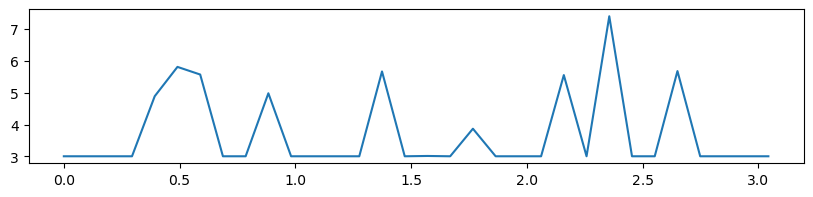

In [8]:
# Iterate over each connected component
D = 32
Np = 256
kp = 5
epsilon = 3

Vp = np.zeros((num_labels,D))

angles = np.pi/32 * np.arange(0,D)

for angleNum in range(0,angles.shape[0]):
    # Calculate the rotation matrix
    M = cv2.getRotationMatrix2D(center=centerPadded, angle=np.rad2deg(angles[angleNum]),scale=1)
    rotated = cv2.warpAffine(ellipseMask,M,(ellipseMask.shape[1],ellipseMask.shape[0]))
    #Rotate all centroids by angle
    rotated_centroids = np.dot(M,np.append(centroids, np.ones((num_labels,1)), axis=1).T).T[:,:2]

    _, rotated = cv2.threshold(rotated, 127, 255, cv2.THRESH_BINARY)

    for centroidNum in range(100,101):#,num_labels):
        #start = time.time()
        xprojection = calcProjection(Np, rotated_centroids[centroidNum] , rotated)
        #end = time.time()
        #print(end-start)

        #start = time.time()
        #Check if xprojection is smaler or equal than 3 for all values
        if np.all(xprojection <= 3):
            Vp[centroidNum,angleNum] = epsilon
        else:
            # Calculate the rfft of the xprojection
            dft = np.fft.rfft(xprojection)
            #print(dft)

            #Check if dft[kp] is local maximum
            if kp > 0 and kp < len(dft)-1:
                if np.abs(dft[kp]) > np.abs(dft[kp-1]) and np.abs(dft[kp]) > np.abs(dft[kp+1]):
                    Vp[centroidNum,angleNum] = -np.log(np.abs(dft[kp])**2/np.abs(dft[0])**2)
                else:
                    Vp[centroidNum,angleNum] = epsilon
        #stop = time.time()
        #print(stop-start)

        
#Plot Vp
plt.figure(figsize=(10,2))
plt.plot(angles,Vp[100,:])
plt.show()

        
